In [1]:
# !pip install nba-api
# !pip install Keras

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# dependencies

# basic
from datetime import datetime
import json
import pandas as pd
from pandas import ExcelFile
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import numpy as np
import requests
import seaborn as sns
import time

# nba api
import nba_api
from nba_api.stats.endpoints import BoxScoreDefensive, BoxScoreMiscV2, BoxScorePlayerTrackV2, BoxScoreUsageV2
from nba_api.stats.static import teams
from nba_api.stats.endpoints import LeagueGameFinder, LeagueGameLog, PlayerGameLog

# sklearn
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, Normalizer, StandardScaler
from sklearn.svm import SVC

# tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

In [119]:
plt.style.use('seaborn')

-------
# csv dataset
-------

In [4]:
# df_final = pd.read_csv('/content/drive/My Drive/mo_bucks_ml/current/gamestatsfinal_version_3.csv')
df_final = pd.read_csv('gamestatsfinal_version_3.csv')

In [5]:
df_final

,AST_PCT,AST_RATIO,AST_TOV,AST,BLK,BLKA,BLK.1,CFGA,CFGM,CFG_PCT,...,TS_TEAM_AVG,UFGA,UFGM,UFG_PCT,USG_PCT,VIDEO_AVAILABLE,WL,YEAR BUILT,ARENA,ATTENDANCE
0,0.214,27.3,3.00,3,0,1,0,2,0,0.000,...,0.480333,5,3,0.600,0.163,1,W,1995,TD Garden,18624
1,0.091,11.1,1.00,2,0,2,0,6,2,0.333,...,0.480333,7,3,0.429,0.229,1,W,1995,TD Garden,18624
2,0.000,0.0,0.00,0,0,1,0,5,1,0.200,...,0.480333,7,3,0.429,0.206,1,W,1995,TD Garden,18624
3,0.095,16.7,0.67,2,4,0,4,3,3,1.000,...,0.480333,4,1,0.250,0.137,1,W,1995,TD Garden,18624
4,0.292,28.0,2.33,7,0,1,0,2,1,0.500,...,0.480333,12,1,0.083,0.247,1,W,1995,TD Garden,18624
5,0.000,0.0,0.00,0,0,0,0,1,1,1.000,...,0.480333,11,6,0.545,0.241,1,W,1995,TD Garden,18624
6,0.000,0.0,0.00,0,0,0,0,0,0,0.000,...,0.480333,0,0,0.000,0.000,1,W,1995,TD Garden,18624
7,0.048,8.3,1.00,1,1,0,1,3,0,0.000,...,0.480333,7,5,0.714,0.167,1,W,1995,TD Garden,18624
8,0.176,30.0,1.50,3,0,0,0,0,0,0.000,...,0.480333,4,2,0.500,0.109,1,W,1995,TD Garden,18624
9,0.250,13.0,3.00,3,0,0,0,5,2,0.400,...,0.480333,12,7,0.583,0.290,1,W,1995,TD Garden,18624


In [6]:
# fix gameid column w/ leading zeros
df_final['GAME_ID'] = df_final['GAME_ID'].map(lambda x: f'{x:0>10}')

In [7]:
df_final.head()

,AST_PCT,AST_RATIO,AST_TOV,AST,BLK,BLKA,BLK.1,CFGA,CFGM,CFG_PCT,...,TS_TEAM_AVG,UFGA,UFGM,UFG_PCT,USG_PCT,VIDEO_AVAILABLE,WL,YEAR BUILT,ARENA,ATTENDANCE
0,0.214,27.3,3.00,3,0,1,0,2,0,0.000,...,0.480333,5,3,0.600,0.163,1,W,1995,TD Garden,18624
1,0.091,11.1,1.00,2,0,2,0,6,2,0.333,...,0.480333,7,3,0.429,0.229,1,W,1995,TD Garden,18624
2,0.000,0.0,0.00,0,0,1,0,5,1,0.200,...,0.480333,7,3,0.429,0.206,1,W,1995,TD Garden,18624
3,0.095,16.7,0.67,2,4,0,4,3,3,1.000,...,0.480333,4,1,0.250,0.137,1,W,1995,TD Garden,18624
4,0.292,28.0,2.33,7,0,1,0,2,1,0.500,...,0.480333,12,1,0.083,0.247,1,W,1995,TD Garden,18624


# player selection

In [9]:
# dfplayerawards = pd.read_csv('/content/drive/My Drive/mo_bucks_ml/current/2019_nba_awards.csv')
dfplayerawards = pd.read_csv('2019_nba_awards.csv')

In [10]:
players_awarded = dfplayerawards['Player'].unique()

In [11]:
df_final_awarded = df_final.loc[df_final['PLAYER_NAME'].isin(players_awarded)]

# feature selection

In [12]:
list(df_final.keys())

['AST_PCT',
 'AST_RATIO',
 'AST_TOV',
 'AST',
 'BLK',
 'BLKA',
 'BLK.1',
 'CFGA',
 'CFGM',
 'CFG_PCT',
 'COMMENT',
 'Capacity',
 'Capacity_pct',
 'City',
 'DEF_RATING',
 'DFGA',
 'DFGM',
 'DFG_PCT',
 'DIST',
 'DRBC',
 'DREB_PCT',
 'DREB',
 'EFG_EVAL',
 'EFG_PCT',
 'EFG_TEAM_AVG',
 'E_DEF_RATING',
 'E_NET_RATING',
 'E_OFF_RATING',
 'E_PACE',
 'E_USG_PCT',
 'FG3A',
 'FG3M',
 'FG3_PCT',
 'FGA',
 'FGM',
 'FG_PCT',
 'FTA',
 'FTAST',
 'FTM',
 'FT_PCT',
 'FT_missed',
 'GAME_DATE',
 'GAME_ID',
 'GAMESCORE',
 'Home/Away',
 'Hometeam',
 'MATCHUP',
 'MATCHUP_AST',
 'MATCHUP_FG3A',
 'MATCHUP_FG3M',
 'MATCHUP_FG3_PCT',
 'MATCHUP_FGA',
 'MATCHUP_FGM',
 'MATCHUP_FG_PCT',
 'MATCHUP_MIN',
 'MATCHUP_TOV',
 'MIN',
 'MIN_FLAT',
 'NET_RATING',
 'OFF_RATING',
 'OPP_PTS_2ND_CHANCE',
 'OPP_PTS_FB',
 'OPP_PTS_OFF_TOV',
 'OPP_PTS_PAINT',
 'ORBC',
 'OREB',
 'OREB_PCT',
 'PACE',
 'PACE_PER40',
 'PARTIAL_POSS',
 'PASS',
 'PCT_AST',
 'PCT_BLK',
 'PCT_BLKA',
 'PCT_DREB',
 'PCT_FG3A',
 'PCT_FG3M',
 'PCT_FGA',
 'PCT_F

In [13]:
features = [
    
#   target
    'START_POSITION',
    
#   categorical
    'WL',
    
#   traditional
    'PTS',
    'AST',
    'PF',
#   'DEF_RATING',
#   'OFF_RATING',
    'FG_PCT',
    'FG3M',
    'FTM',
    'FGM',
    'STL',
    'TOV',
    'Home/Away',
    
#   minutes/usage/possession
    'MIN_FLAT',
    'USG_PCT',
    'POSS',
    
#   point types
    'PTS_2ND_CHANCE',
    'PTS_FB',
    'PTS_OFF_TOV',
    'PTS_PAINT',

#   advanced
    'GAMESCORE',
    'EFG_PCT',
    'TS_PCT',
#   eval => pct above or below team average
    'EFG_EVAL',
    'TS_EVAL',
    
#   granular
    'SPD', # speed
    'DIST', # distance
    'ORBC', # oreb chances
    'DRBC', # dreb chances
    'RBC', # reb chances
    'TCHS', # touches
    'SAST', # secondary assists
    'FTAST', # free throw assists
    'PFD', # personal fouls drawn
    'PASS', # passes
    'CFGM', # contested fgm
    'CFGA', # contested fga
    'CFG_PCT', # contested fg pct
    'UFGM', # uncontested fgm
    'UFGA', # uncontested fga
    'UFG_PCT', # uncontested fg pct
    'DFGM', # defended fgm
    'DFGA', # defended fga
    'DFG_PCT', # defended df pct
    
#   percent of team stats
    'PCT_FGM',
    'PCT_FGA',
    'PCT_FG3M',
    'PCT_FG3A',
    'PCT_FTM',
    'PCT_FTA',
    'PCT_OREB',
    'PCT_DREB',
    'PCT_REB',
    'PCT_AST',
    'PCT_TOV',
    'PCT_STL',
    'PCT_BLK',
    'PCT_BLKA',
    'PCT_PF',
    'PCT_PFD',
    'PCT_PTS',
    
#     arena
#    'Capacity_pct',
#    'Capacity',
    
]

In [14]:
len(features)

60

--------
# svc model
--------

In [15]:
df_svc = df_final[features].copy()

In [22]:
df_svc = df_svc[pd.notnull(df_svc['START_POSITION'])]

In [23]:
df_svc.head()

,START_POSITION,WL,PTS,AST,PF,FG_PCT,FG3M,FTM,FGM,STL,...,PCT_DREB,PCT_REB,PCT_AST,PCT_TOV,PCT_STL,PCT_BLK,PCT_BLKA,PCT_PF,PCT_PFD,PCT_PTS
1,G,W,12,2,4,0.385,1,1,5,0,...,0.083,0.172,0.105,0.286,0.000,0.0,0.667,0.364,0.077,0.171
2,F,W,10,0,1,0.333,1,1,4,4,...,0.143,0.172,0.000,0.000,0.667,0.0,0.500,0.111,0.385,0.192
3,C,W,9,2,1,0.571,0,1,4,0,...,0.138,0.121,0.118,0.300,0.000,1.0,0.000,0.091,0.143,0.134
4,G,W,7,7,1,0.143,1,2,2,0,...,0.154,0.129,0.389,0.333,0.000,0.0,0.250,0.077,0.143,0.103
9,F,W,23,3,2,0.529,1,4,9,1,...,0.269,0.300,0.300,0.091,0.250,0.0,0.000,0.167,0.231,0.426


In [24]:
positions = df_svc['START_POSITION'].unique()
positions

array(['G', 'F', 'C'], dtype=object)

In [25]:
encoder = LabelEncoder()
encoder.fit(df_svc['START_POSITION'])
y = encoder.transform(df_svc['START_POSITION'])
df_svc['START_POSITION'] = y

In [26]:
encoder = LabelEncoder()
encoder.fit(df_svc['WL'])
wl = encoder.transform(df_svc.WL)
df_svc['WL'] = wl

In [27]:
encoder = LabelEncoder()
encoder.fit(df_svc['Home/Away'])
home = encoder.transform(df_svc['Home/Away'])
df_svc['HOME'] = home

In [28]:
df_svc

,START_POSITION,WL,PTS,AST,PF,FG_PCT,FG3M,FTM,FGM,STL,...,PCT_REB,PCT_AST,PCT_TOV,PCT_STL,PCT_BLK,PCT_BLKA,PCT_PF,PCT_PFD,PCT_PTS,HOME
1,2,1,12,2,4,0.385,1,1,5,0,...,0.172,0.105,0.286,0.000,0.000,0.667,0.364,0.077,0.171,1
2,1,1,10,0,1,0.333,1,1,4,4,...,0.172,0.000,0.000,0.667,0.000,0.500,0.111,0.385,0.192,1
3,0,1,9,2,1,0.571,0,1,4,0,...,0.121,0.118,0.300,0.000,1.000,0.000,0.091,0.143,0.134,1
4,2,1,7,7,1,0.143,1,2,2,0,...,0.129,0.389,0.333,0.000,0.000,0.250,0.077,0.143,0.103,1
9,1,1,23,3,2,0.529,1,4,9,1,...,0.300,0.300,0.091,0.250,0.000,0.000,0.167,0.231,0.426,1
13,1,0,8,0,1,0.300,2,0,3,2,...,0.167,0.000,0.200,0.333,0.333,0.000,0.077,0.071,0.119,0
14,0,0,23,2,3,0.429,1,4,9,1,...,0.250,0.133,0.385,0.200,0.400,0.750,0.200,0.214,0.333,0
15,2,0,5,2,1,0.286,0,1,2,1,...,0.115,0.222,0.273,0.500,0.000,0.000,0.100,0.250,0.119,0
19,1,0,6,1,5,0.375,0,0,3,0,...,0.273,0.125,0.375,0.000,0.000,0.000,0.455,0.091,0.136,0
21,2,0,19,8,5,0.500,0,5,7,4,...,0.333,0.471,0.231,0.500,0.400,0.200,0.294,0.444,0.238,0


In [29]:
target = df_svc['START_POSITION']
data = df_svc.drop(['START_POSITION', 'Home/Away'], axis=1)
feature_names = data.columns

In [30]:
data

,WL,PTS,AST,PF,FG_PCT,FG3M,FTM,FGM,STL,TOV,...,PCT_REB,PCT_AST,PCT_TOV,PCT_STL,PCT_BLK,PCT_BLKA,PCT_PF,PCT_PFD,PCT_PTS,HOME
1,1,12,2,4,0.385,1,1,5,0,2,...,0.172,0.105,0.286,0.000,0.000,0.667,0.364,0.077,0.171,1
2,1,10,0,1,0.333,1,1,4,4,0,...,0.172,0.000,0.000,0.667,0.000,0.500,0.111,0.385,0.192,1
3,1,9,2,1,0.571,0,1,4,0,3,...,0.121,0.118,0.300,0.000,1.000,0.000,0.091,0.143,0.134,1
4,1,7,7,1,0.143,1,2,2,0,3,...,0.129,0.389,0.333,0.000,0.000,0.250,0.077,0.143,0.103,1
9,1,23,3,2,0.529,1,4,9,1,1,...,0.300,0.300,0.091,0.250,0.000,0.000,0.167,0.231,0.426,1
13,0,8,0,1,0.300,2,0,3,2,2,...,0.167,0.000,0.200,0.333,0.333,0.000,0.077,0.071,0.119,0
14,0,23,2,3,0.429,1,4,9,1,5,...,0.250,0.133,0.385,0.200,0.400,0.750,0.200,0.214,0.333,0
15,0,5,2,1,0.286,0,1,2,1,3,...,0.115,0.222,0.273,0.500,0.000,0.000,0.100,0.250,0.119,0
19,0,6,1,5,0.375,0,0,3,0,3,...,0.273,0.125,0.375,0.000,0.000,0.000,0.455,0.091,0.136,0
21,0,19,8,5,0.500,0,5,7,4,3,...,0.333,0.471,0.231,0.500,0.400,0.200,0.294,0.444,0.238,0


In [31]:
# X_train, X_test, y_train, y_test = train_test_split(data[:5000], target[:5000], random_state=42)

X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42)

In [32]:
y_train.head()

6931     1
16333    2
4641     2
9557     1
8894     1
Name: START_POSITION, dtype: int64

In [33]:
y_test.head()

12634    2
8877     1
11022    1
14432    1
10912    1
Name: START_POSITION, dtype: int64

In [34]:
X_test

,WL,PTS,AST,PF,FG_PCT,FG3M,FTM,FGM,STL,TOV,...,PCT_REB,PCT_AST,PCT_TOV,PCT_STL,PCT_BLK,PCT_BLKA,PCT_PF,PCT_PFD,PCT_PTS,HOME
12634,1,9,1,4,0.600,3,0,3,0,1,...,0.056,0.100,0.100,0.000,0.000,0.000,0.286,0.000,0.205,0
8877,0,13,8,4,0.417,3,0,5,3,2,...,0.143,0.308,0.200,0.300,0.000,0.000,0.267,0.071,0.160,1
11022,1,21,1,2,0.474,1,2,9,1,1,...,0.138,0.040,0.077,0.071,0.000,0.200,0.125,0.231,0.239,1
14432,1,15,2,1,0.444,0,7,4,0,1,...,0.524,0.333,0.167,0.000,0.000,0.250,0.100,0.556,0.405,0
10912,0,10,1,0,0.231,1,3,3,1,0,...,0.300,0.143,0.000,0.143,0.000,0.333,0.000,0.214,0.169,0
14738,1,14,0,3,0.545,0,2,6,2,1,...,0.167,0.000,0.143,0.182,1.000,1.000,0.375,0.214,0.255,1
11072,0,14,1,2,0.500,3,1,5,1,0,...,0.259,0.067,0.000,0.500,0.000,0.000,0.167,0.077,0.212,0
9592,0,4,2,2,0.200,0,2,1,1,3,...,0.158,0.167,0.333,0.200,0.250,0.000,0.250,0.167,0.078,1
7039,1,14,0,6,0.556,0,4,5,0,1,...,0.480,0.000,0.111,0.000,1.000,0.000,0.400,0.333,0.215,0
8330,1,12,2,1,0.625,2,0,5,0,2,...,0.107,0.125,0.400,0.000,0.000,0.000,0.091,0.077,0.164,1


In [35]:
model = SVC(C= 5, 
        gamma= 0.01, 
        kernel= 'rbf',
        verbose=True)

In [36]:
model.fit(X_train, y_train)

[LibSVM]

SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=True)

In [37]:
predictions_svc = model.predict(X_test)

In [38]:
X_test['predictions_svc'] = predictions_svc
X_test['target'] = target

/Users/andrew/anaconda3/envs/bootcamp/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/andrew/anaconda3/envs/bootcamp/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [39]:
X_test

,WL,PTS,AST,PF,FG_PCT,FG3M,FTM,FGM,STL,TOV,...,PCT_TOV,PCT_STL,PCT_BLK,PCT_BLKA,PCT_PF,PCT_PFD,PCT_PTS,HOME,predictions_svc,target
12634,1,9,1,4,0.600,3,0,3,0,1,...,0.100,0.000,0.000,0.000,0.286,0.000,0.205,0,1,2
8877,0,13,8,4,0.417,3,0,5,3,2,...,0.200,0.300,0.000,0.000,0.267,0.071,0.160,1,1,1
11022,1,21,1,2,0.474,1,2,9,1,1,...,0.077,0.071,0.000,0.200,0.125,0.231,0.239,1,1,1
14432,1,15,2,1,0.444,0,7,4,0,1,...,0.167,0.000,0.000,0.250,0.100,0.556,0.405,0,0,1
10912,0,10,1,0,0.231,1,3,3,1,0,...,0.000,0.143,0.000,0.333,0.000,0.214,0.169,0,1,1
14738,1,14,0,3,0.545,0,2,6,2,1,...,0.143,0.182,1.000,1.000,0.375,0.214,0.255,1,0,1
11072,0,14,1,2,0.500,3,1,5,1,0,...,0.000,0.500,0.000,0.000,0.167,0.077,0.212,0,1,1
9592,0,4,2,2,0.200,0,2,1,1,3,...,0.333,0.200,0.250,0.000,0.250,0.167,0.078,1,2,2
7039,1,14,0,6,0.556,0,4,5,0,1,...,0.111,0.000,1.000,0.000,0.400,0.333,0.215,0,0,0
8330,1,12,2,1,0.625,2,0,5,0,2,...,0.400,0.000,0.000,0.000,0.091,0.077,0.164,1,1,1


In [48]:
print(classification_report(y_test, predictions_svc, target_names=['Center','Forward','Guard']))

              precision    recall  f1-score   support

      Center       0.71      0.64      0.67       567
     Forward       0.60      0.59      0.59      1212
       Guard       0.66      0.70      0.68      1158

    accuracy                           0.64      2937
   macro avg       0.65      0.64      0.65      2937
weighted avg       0.64      0.64      0.64      2937



In [49]:
list(features)

['START_POSITION',
 'WL',
 'PTS',
 'AST',
 'PF',
 'FG_PCT',
 'FG3M',
 'FTM',
 'FGM',
 'STL',
 'TOV',
 'Home/Away',
 'MIN_FLAT',
 'USG_PCT',
 'POSS',
 'PTS_2ND_CHANCE',
 'PTS_FB',
 'PTS_OFF_TOV',
 'PTS_PAINT',
 'GAMESCORE',
 'EFG_PCT',
 'TS_PCT',
 'EFG_EVAL',
 'TS_EVAL',
 'SPD',
 'DIST',
 'ORBC',
 'DRBC',
 'RBC',
 'TCHS',
 'SAST',
 'FTAST',
 'PFD',
 'PASS',
 'CFGM',
 'CFGA',
 'CFG_PCT',
 'UFGM',
 'UFGA',
 'UFG_PCT',
 'DFGM',
 'DFGA',
 'DFG_PCT',
 'PCT_FGM',
 'PCT_FGA',
 'PCT_FG3M',
 'PCT_FG3A',
 'PCT_FTM',
 'PCT_FTA',
 'PCT_OREB',
 'PCT_DREB',
 'PCT_REB',
 'PCT_AST',
 'PCT_TOV',
 'PCT_STL',
 'PCT_BLK',
 'PCT_BLKA',
 'PCT_PF',
 'PCT_PFD',
 'PCT_PTS']

In [43]:
dfpred = pd.concat([df_final, X_test], axis=1)

In [53]:
dfplayerpred = dfpred[['START_POSITION','PLAYER_NAME', 'TEAM_NICKNAME', 'MATCHUP', 'predictions_svc', 'target']].copy().dropna()

In [54]:
dfplayerpred

,START_POSITION,PLAYER_NAME,TEAM_NICKNAME,MATCHUP,predictions_svc,target
1,G,Jaylen Brown,Celtics,BOS vs. PHI,1.0,2.0
4,G,Kyrie Irving,Celtics,BOS vs. PHI,2.0,2.0
19,F,Dario Saric,76ers,PHI @ BOS,0.0,1.0
24,G,Stephen Curry,Warriors,GSW vs. OKC,1.0,2.0
31,G,Klay Thompson,Warriors,GSW vs. OKC,2.0,2.0
39,G,Dennis Schroder,Thunder,OKC @ GSW,2.0,2.0
47,C,Brook Lopez,Bucks,MIL @ CHA,2.0,0.0
59,C,Cody Zeller,Hornets,CHA vs. MIL,1.0,0.0
63,F,Jared Dudley,Nets,BKN @ DET,1.0,1.0
65,F,Joe Harris,Nets,BKN @ DET,1.0,1.0


In [55]:
dfplayerpred['correct_svc'] = 0

In [56]:
for index, row in dfplayerpred.iterrows():
    
    if row['predictions_svc'] == row['target']:
        dfplayerpred.loc[index, 'correct_svc'] = 'correct'
    if row['predictions_svc'] != row['target']:
        dfplayerpred.loc[index, 'correct_svc'] = 'wrong'

In [57]:
dfplayerpred.loc[(dfplayerpred['correct_svc'] == 'correct')]

,START_POSITION,PLAYER_NAME,TEAM_NICKNAME,MATCHUP,predictions_svc,target,correct_svc
4,G,Kyrie Irving,Celtics,BOS vs. PHI,2.0,2.0,correct
31,G,Klay Thompson,Warriors,GSW vs. OKC,2.0,2.0,correct
39,G,Dennis Schroder,Thunder,OKC @ GSW,2.0,2.0,correct
63,F,Jared Dudley,Nets,BKN @ DET,1.0,1.0,correct
65,F,Joe Harris,Nets,BKN @ DET,1.0,1.0,correct
67,G,Caris LeVert,Nets,BKN @ DET,2.0,2.0,correct
69,G,Bruce Brown,Pistons,DET vs. BKN,2.0,2.0,correct
70,C,Andre Drummond,Pistons,DET vs. BKN,0.0,0.0,correct
74,F,Luke Kennard,Pistons,DET vs. BKN,1.0,1.0,correct
94,F,Chandler Parsons,Grizzlies,MEM @ IND,1.0,1.0,correct


## grid

In [58]:
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42)

In [59]:
model = SVC()

# param_grid = {'C': [0.001, 0.1, 1, 5, 10, 100],
#               'gamma': [0.001, 0.01, 0.1, 1, 10, 100],
#               'kernel':['rbf']}

param_grid = {'C': [0.1, 1, 5],
              'gamma': [0.001, 0.01, 0.1, 1],
              'kernel':['rbf']}

grid = GridSearchCV(model, param_grid, verbose=3)

In [60]:
grid.fit(X_train, y_train)

/Users/andrew/anaconda3/envs/bootcamp/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.665, total=   2.7s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s


[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.664, total=   2.7s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.5s remaining:    0.0s


[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.681, total=   2.7s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.543, total=   3.7s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.534, total=   3.8s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.541, total=   3.8s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.404, total=   4.5s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.404, total=   4.4s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.404, total=   4.3s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  2.3min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 1, 5], 'gamma': [0.001, 0.01, 0.1, 1],
                         'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [61]:
grid.best_params_

{'C': 5, 'gamma': 0.001, 'kernel': 'rbf'}

In [62]:
grid.best_score_

0.7091940976163451

In [63]:
predictions_grid = grid.predict(X_test)

In [64]:
predictions_grid

array([2, 2, 1, ..., 0, 0, 1])

In [65]:
X_test['predictions_grid'] = predictions_grid
X_test['target'] = target

/Users/andrew/anaconda3/envs/bootcamp/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/andrew/anaconda3/envs/bootcamp/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [66]:
print(classification_report(y_test, predictions_grid,
                            target_names=["Center (0)", "Forward (1)", "Guard (2)"]))

              precision    recall  f1-score   support

  Center (0)       0.79      0.74      0.76       567
 Forward (1)       0.67      0.71      0.69      1212
   Guard (2)       0.76      0.73      0.74      1158

    accuracy                           0.72      2937
   macro avg       0.74      0.73      0.73      2937
weighted avg       0.73      0.72      0.72      2937



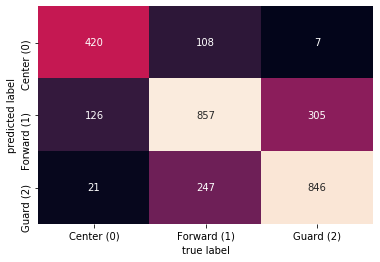

In [67]:
matrix = confusion_matrix(y_test, predictions_grid)
sns.heatmap(matrix.T, annot=True, fmt='d', cbar=False,
            xticklabels=["Center (0)", "Forward (1)", "Guard (2)"],
            yticklabels=["Center (0)", "Forward (1)", "Guard (2)"])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [68]:
matrix.T

array([[420, 108,   7],
       [126, 857, 305],
       [ 21, 247, 846]])

In [69]:
dfpred = pd.concat([df_final, X_test], axis=1)

In [70]:
dfpred

,AST_PCT,AST_RATIO,AST_TOV,AST,BLK,BLKA,BLK.1,CFGA,CFGM,CFG_PCT,...,PCT_TOV,PCT_STL,PCT_BLK,PCT_BLKA,PCT_PF,PCT_PFD,PCT_PTS,HOME,predictions_grid,target
0,0.214,27.3,3.00,3,0,1,0,2,0,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.091,11.1,1.00,2,0,2,0,6,2,0.333,...,0.286,0.000,0.0,0.667,0.364,0.077,0.171,1.0,2.0,2.0
2,0.000,0.0,0.00,0,0,1,0,5,1,0.200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.095,16.7,0.67,2,4,0,4,3,3,1.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.292,28.0,2.33,7,0,1,0,2,1,0.500,...,0.333,0.000,0.0,0.250,0.077,0.143,0.103,1.0,2.0,2.0
5,0.000,0.0,0.00,0,0,0,0,1,1,1.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.000,0.0,0.00,0,0,0,0,0,0,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.048,8.3,1.00,1,1,0,1,3,0,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.176,30.0,1.50,3,0,0,0,0,0,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.250,13.0,3.00,3,0,0,0,5,2,0.400,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [72]:
dfplayerpred = dfpred[['PLAYER_NAME', 'TEAM_NICKNAME', 'MATCHUP', 'predictions_grid', 'target', 'START_POSITION']].copy().dropna()

In [73]:
dfplayerpred

,PLAYER_NAME,TEAM_NICKNAME,MATCHUP,predictions_grid,target,START_POSITION
1,Jaylen Brown,Celtics,BOS vs. PHI,2.0,2.0,G
4,Kyrie Irving,Celtics,BOS vs. PHI,2.0,2.0,G
19,Dario Saric,76ers,PHI @ BOS,0.0,1.0,F
24,Stephen Curry,Warriors,GSW vs. OKC,2.0,2.0,G
31,Klay Thompson,Warriors,GSW vs. OKC,2.0,2.0,G
39,Dennis Schroder,Thunder,OKC @ GSW,2.0,2.0,G
47,Brook Lopez,Bucks,MIL @ CHA,1.0,0.0,C
59,Cody Zeller,Hornets,CHA vs. MIL,1.0,0.0,C
63,Jared Dudley,Nets,BKN @ DET,1.0,1.0,F
65,Joe Harris,Nets,BKN @ DET,1.0,1.0,F


In [74]:
dfplayerpred['correct_grid'] = 0
dfplayerpred['wrong_grid'] = 0

In [75]:
for index, row in dfplayerpred.iterrows():
    
    if row[3] == row['target']:
        dfplayerpred.loc[index, 'correct_grid'] = 1
        
    if row[3] != row['target']:
        dfplayerpred.loc[index, 'wrong_grid'] = 1

In [76]:
dfplayerpred

,PLAYER_NAME,TEAM_NICKNAME,MATCHUP,predictions_grid,target,START_POSITION,correct_grid,wrong_grid
1,Jaylen Brown,Celtics,BOS vs. PHI,2.0,2.0,G,1,0
4,Kyrie Irving,Celtics,BOS vs. PHI,2.0,2.0,G,1,0
19,Dario Saric,76ers,PHI @ BOS,0.0,1.0,F,0,1
24,Stephen Curry,Warriors,GSW vs. OKC,2.0,2.0,G,1,0
31,Klay Thompson,Warriors,GSW vs. OKC,2.0,2.0,G,1,0
39,Dennis Schroder,Thunder,OKC @ GSW,2.0,2.0,G,1,0
47,Brook Lopez,Bucks,MIL @ CHA,1.0,0.0,C,0,1
59,Cody Zeller,Hornets,CHA vs. MIL,1.0,0.0,C,0,1
63,Jared Dudley,Nets,BKN @ DET,1.0,1.0,F,1,0
65,Joe Harris,Nets,BKN @ DET,1.0,1.0,F,1,0


In [77]:
groupbygrid = dfplayerpred.groupby(by='PLAYER_NAME').sum()[['correct_grid', 'wrong_grid']].copy()

In [78]:
df = pd.DataFrame(groupbygrid)
df['differential_grid'] = 0
df['correct_grid_pct'] = 0
df['wrong_grid_pct'] = 0

In [79]:
for index, row in df.iterrows():
    differential = (row['correct_grid'] - row['wrong_grid']) / (row['correct_grid'] + row['wrong_grid'])
    df.loc[index, 'differential_grid'] = differential
    
    correct_pct = (row['correct_grid']) / (row['correct_grid'] + row['wrong_grid'])
    df.loc[index, 'correct_grid_pct'] = correct_pct

    wrong_pct = (row['wrong_grid']) / (row['correct_grid'] + row['wrong_grid'])
    df.loc[index, 'wrong_grid_pct'] = wrong_pct


In [80]:
df.sort_values(by='correct_grid_pct').tail(20)

,correct_grid,wrong_grid,differential_grid,correct_grid_pct,wrong_grid_pct
PLAYER_NAME,,,,,
P.J. Tucker,16,0,1.0,1.0,0.0
OG Anunoby,1,0,1.0,1.0,0.0
Norman Powell,2,0,1.0,1.0,0.0
Moritz Wagner,1,0,1.0,1.0,0.0
Monte Morris,1,0,1.0,1.0,0.0
Miles Bridges,5,0,1.0,1.0,0.0
Mike Conley,20,0,1.0,1.0,0.0
Michael Kidd-Gilchrist,1,0,1.0,1.0,0.0
Marvin Williams,19,0,1.0,1.0,0.0


In [82]:
df.sort_values(by='wrong_grid_pct').tail(20)

,correct_grid,wrong_grid,differential_grid,correct_grid_pct,wrong_grid_pct
PLAYER_NAME,,,,,
Blake Griffin,3,10,-0.538462,0.230769,0.769231
Landry Shamet,1,4,-0.600000,0.200000,0.800000
Jabari Parker,1,4,-0.600000,0.200000,0.800000
Brook Lopez,4,18,-0.636364,0.181818,0.818182
John Collins,3,14,-0.647059,0.176471,0.823529
Jeremy Lamb,1,15,-0.875000,0.062500,0.937500
Yogi Ferrell,0,1,-1.000000,0.000000,1.000000
Mitchell Robinson,0,1,-1.000000,0.000000,1.000000
Pat Connaughton,0,1,-1.000000,0.000000,1.000000


----------
# neural net
----------

In [96]:
df_nnet = df_final[features]

In [97]:
df_nnet = df_nnet[pd.notnull(df_nnet['START_POSITION'])]

In [98]:
positions = df_nnet['START_POSITION'].unique()
positions

array(['G', 'F', 'C'], dtype=object)

In [99]:
data = df_nnet.copy()

In [100]:
data.head()

,START_POSITION,WL,PTS,AST,PF,FG_PCT,FG3M,FTM,FGM,STL,...,PCT_DREB,PCT_REB,PCT_AST,PCT_TOV,PCT_STL,PCT_BLK,PCT_BLKA,PCT_PF,PCT_PFD,PCT_PTS
1,G,W,12,2,4,0.385,1,1,5,0,...,0.083,0.172,0.105,0.286,0.000,0.0,0.667,0.364,0.077,0.171
2,F,W,10,0,1,0.333,1,1,4,4,...,0.143,0.172,0.000,0.000,0.667,0.0,0.500,0.111,0.385,0.192
3,C,W,9,2,1,0.571,0,1,4,0,...,0.138,0.121,0.118,0.300,0.000,1.0,0.000,0.091,0.143,0.134
4,G,W,7,7,1,0.143,1,2,2,0,...,0.154,0.129,0.389,0.333,0.000,0.0,0.250,0.077,0.143,0.103
9,F,W,23,3,2,0.529,1,4,9,1,...,0.269,0.300,0.300,0.091,0.250,0.0,0.000,0.167,0.231,0.426


In [101]:
# encoder = LabelEncoder()
# encoder.fit(data['WL'])
# encoder.classes_
# y = encoder.transform(data.WL)
# y

encoder = LabelEncoder()
encoder.fit(data['START_POSITION'])
y = encoder.transform(data['START_POSITION'])

encoder = LabelEncoder()
encoder.fit(data['WL'])
wl = encoder.transform(data.WL)
data['WL'] = wl

encoder = LabelEncoder()
encoder.fit(data['Home/Away'])
home = encoder.transform(data['Home/Away'])
data['HOME'] = home

In [102]:
# encoder = LabelEncoder()
# encoder.fit(data['Home/Away'])
# home = encoder.transform(data['Home/Away'])
# data['HOME'] = home

In [103]:
data.drop(columns=['Home/Away', 'START_POSITION'], inplace=True)
# X = data.values
X = data
X

,WL,PTS,AST,PF,FG_PCT,FG3M,FTM,FGM,STL,TOV,...,PCT_REB,PCT_AST,PCT_TOV,PCT_STL,PCT_BLK,PCT_BLKA,PCT_PF,PCT_PFD,PCT_PTS,HOME
1,1,12,2,4,0.385,1,1,5,0,2,...,0.172,0.105,0.286,0.000,0.000,0.667,0.364,0.077,0.171,1
2,1,10,0,1,0.333,1,1,4,4,0,...,0.172,0.000,0.000,0.667,0.000,0.500,0.111,0.385,0.192,1
3,1,9,2,1,0.571,0,1,4,0,3,...,0.121,0.118,0.300,0.000,1.000,0.000,0.091,0.143,0.134,1
4,1,7,7,1,0.143,1,2,2,0,3,...,0.129,0.389,0.333,0.000,0.000,0.250,0.077,0.143,0.103,1
9,1,23,3,2,0.529,1,4,9,1,1,...,0.300,0.300,0.091,0.250,0.000,0.000,0.167,0.231,0.426,1
13,0,8,0,1,0.300,2,0,3,2,2,...,0.167,0.000,0.200,0.333,0.333,0.000,0.077,0.071,0.119,0
14,0,23,2,3,0.429,1,4,9,1,5,...,0.250,0.133,0.385,0.200,0.400,0.750,0.200,0.214,0.333,0
15,0,5,2,1,0.286,0,1,2,1,3,...,0.115,0.222,0.273,0.500,0.000,0.000,0.100,0.250,0.119,0
19,0,6,1,5,0.375,0,0,3,0,3,...,0.273,0.125,0.375,0.000,0.000,0.000,0.455,0.091,0.136,0
21,0,19,8,5,0.500,0,5,7,4,3,...,0.333,0.471,0.231,0.500,0.400,0.200,0.294,0.444,0.238,0


In [104]:
len(y), len(X)

(11747, 11747)

In [145]:
y

array([2, 1, 0, ..., 0, 2, 2])

In [105]:
y_categorical = to_categorical(y)
y_categorical

array([[0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, random_state=42)

In [107]:
X_scaler = MinMaxScaler().fit(X_train)
y_scaler = MinMaxScaler().fit(y_train)

# X_scaler = StandardScaler().fit(X_train)
# y_scaler = StandardScaler().fit(y_train)

In [108]:
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [109]:
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [110]:
X_train_scaled[0]

array([1.        , 0.16393443, 0.08333333, 0.16666667, 0.5       ,
       0.14285714, 0.        , 0.2       , 0.28571429, 0.27272727,
       0.43396226, 0.29289428, 0.45614035, 0.        , 0.17647059,
       0.        , 0.11111111, 0.28547855, 0.41666667, 0.41666667,
       0.40963455, 0.41963138, 0.82449726, 0.49271845, 0.22727273,
       0.23333333, 0.28205128, 0.27210884, 0.        , 0.        ,
       0.        , 0.29292929, 0.0625    , 0.12      , 0.333     ,
       0.2       , 0.19230769, 0.6       , 0.15384615, 0.14285714,
       0.667     , 0.2175    , 0.2619469 , 0.333     , 0.222     ,
       0.        , 0.        , 0.167     , 0.227     , 0.28533333,
       0.133     , 0.75      , 0.5       , 0.333     , 1.        ,
       0.125     , 0.        , 0.1797066 , 1.        ])

In [111]:
y_train_scaled[0]

array([0., 1., 0.], dtype=float32)

In [112]:
X_train_scaled.shape, y_train_scaled.shape

((8810, 59), (8810, 3))

In [113]:
model = Sequential(name='NBA_Model')

# input layer
model.add(Dense(units=50, activation='relu', input_dim=X_train_scaled.shape[1], kernel_initializer='he_normal'))

# hidden layers
model.add(Dense(units=100, activation='relu'))
# model.add(Dense(units=100, activation='relu'))
# model.add(Dense(units=75, activation='relu'))
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=25, activation='relu'))

# output layer
# model.add(Dense(units=y_train.shape[1], activation='sigmoid'))
model.add(Dense(units=y_train.shape[1], activation='softmax'))

In [114]:
model.summary()

Model: "NBA_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                3000      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 78        
Total params: 14,503
Trainable params: 14,503
Non-trainable params: 0
_________________________________________________________________


In [115]:
optimizer_sgd = SGD(lr = 0.01, 
                    momentum = 0.9)

In [116]:
model.compile(
#     optimizer='adam',
    optimizer=optimizer_sgd,
#     loss='binary_crossentropy',
    loss='categorical_crossentropy',
#   loss='categorical_hinge',
    metrics=['accuracy']
)

In [117]:
model.fit(
    X_train_scaled,
    y_train_scaled,
    epochs=50,
    shuffle=True,
    verbose=2,
    validation_data=[X_test_scaled, y_test_scaled]
)

Train on 8810 samples, validate on 2937 samples
Epoch 1/50
8810/8810 - 1s - loss: 0.7902 - accuracy: 0.6040 - val_loss: 0.6815 - val_accuracy: 0.6694
Epoch 2/50
8810/8810 - 0s - loss: 0.6708 - accuracy: 0.6797 - val_loss: 0.6929 - val_accuracy: 0.6616
Epoch 3/50
8810/8810 - 0s - loss: 0.6484 - accuracy: 0.6925 - val_loss: 0.6767 - val_accuracy: 0.6769
Epoch 4/50
8810/8810 - 0s - loss: 0.6342 - accuracy: 0.7016 - val_loss: 0.6335 - val_accuracy: 0.6956
Epoch 5/50
8810/8810 - 0s - loss: 0.6168 - accuracy: 0.7051 - val_loss: 0.6362 - val_accuracy: 0.6942
Epoch 6/50
8810/8810 - 0s - loss: 0.6153 - accuracy: 0.7033 - val_loss: 0.6275 - val_accuracy: 0.7058
Epoch 7/50
8810/8810 - 0s - loss: 0.6087 - accuracy: 0.7129 - val_loss: 0.6634 - val_accuracy: 0.6854
Epoch 8/50
8810/8810 - 0s - loss: 0.6008 - accuracy: 0.7124 - val_loss: 0.6132 - val_accuracy: 0.7106
Epoch 9/50
8810/8810 - 0s - loss: 0.6014 - accuracy: 0.7123 - val_loss: 0.6274 - val_accuracy: 0.6922
Epoch 10/50
8810/8810 - 0s - loss:

In [118]:
model_loss, model_accuracy = model.evaluate(
    X_test_scaled, y_test_scaled, verbose=2)
print(f"Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

2937/1 - 0s - loss: 0.5045 - accuracy: 0.7252
Neural Network - Loss: 0.6412960876300703, Accuracy: 0.725229799747467


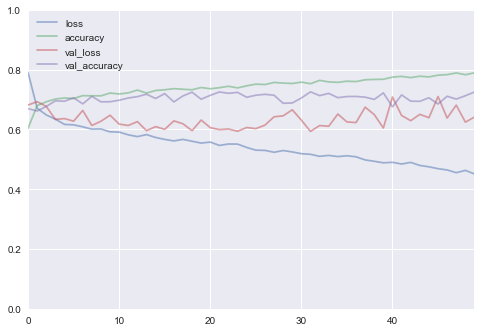

In [120]:
pd.DataFrame(model.history.history).plot(alpha=.5)
plt.gca().set_ylim(0,1)
plt.show()

In [121]:
predictions_nnet = model.predict(X_test_scaled)
predictions_nnet

array([[1.1641533e-05, 6.2105918e-01, 3.7892923e-01],
       [2.1305299e-05, 4.8775220e-01, 5.1222652e-01],
       [3.1445860e-03, 5.4848129e-01, 4.4837409e-01],
       ...,
       [9.7871631e-01, 2.1279333e-02, 4.2638349e-06],
       [9.1660792e-01, 8.3209425e-02, 1.8258953e-04],
       [1.6200411e-03, 8.4371036e-01, 1.5466961e-01]], dtype=float32)

In [159]:
y_test

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

In [171]:
y_test_restored = []

for y in y_test:
    print(y)
    
    cat0 = y[0]
    cat1 = y[1]
    cat2 = y[2]
    
    if cat0 == 1:
        y_test_restored.append(0)
    
    if cat1 == 1:
        y_test_restored.append(1)
    
    if cat2 == 1:
        y_test_restored.append(2)
    
    print('-----')

[0. 0. 1.]
0.0
0.0
1.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[1. 0. 0.]
1.0
0.0
0.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[1. 0. 0.]
1.0
0.0
0.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[1. 0. 0.]
1.0
0.0
0.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[1. 0. 0.]
1.0
0.0
0.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[1. 0. 0.]
1.0
0.0
0.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[1. 0. 0.]
1.0
0.0
0.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[1. 0. 0.]
1.0
0.0
0.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 0. 1.]
0.0

[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[1. 0. 0.]
1.0
0.0
0.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[1. 0. 0.]
1.0
0.0
0.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[1. 0. 0.]
1.0
0.0
0.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[1. 0. 0.]
1.0
0.0
0.0
-----
[1. 0. 0.]
1.0
0.0
0.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[1. 0. 0.]
1.0
0.0
0.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[1. 0. 0.]
1.0
0.0
0.0
-----
[1. 0. 0.]
1.0
0.0
0.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[1. 0. 0.]
1.0
0.0
0.0
-----
[1. 0. 0.]
1.0
0.0
0.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 0. 1.]
0.0

0.0
0.0
1.0
-----
[1. 0. 0.]
1.0
0.0
0.0
-----
[1. 0. 0.]
1.0
0.0
0.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[1. 0. 0.]
1.0
0.0
0.0
-----
[1. 0. 0.]
1.0
0.0
0.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[1. 0. 0.]
1.0
0.0
0.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[1. 0. 0.]
1.0
0.0
0.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[1. 0. 0.]
1.0
0.0
0.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[1. 0. 0.]
1.0
0.0
0.0
-----
[1. 0. 0.]
1.0
0.0
0.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[1. 0. 0.]
1.0
0.0
0.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[1. 0. 0.]
1.0
0.0
0.0
--

[0. 0. 1.]
0.0
0.0
1.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[1. 0. 0.]
1.0
0.0
0.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[1. 0. 0.]
1.0
0.0
0.0
-----
[1. 0. 0.]
1.0
0.0
0.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[1. 0. 0.]
1.0
0.0
0.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[1. 0. 0.]
1.0
0.0
0.0
-----
[1. 0. 0.]
1.0
0.0
0.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[1. 0. 0.]
1.0
0.0
0.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[1. 0. 0.]
1.0
0.0
0.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[1. 0. 0.]
1.0

[1. 0. 0.]
1.0
0.0
0.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[1. 0. 0.]
1.0
0.0
0.0
-----
[1. 0. 0.]
1.0
0.0
0.0
-----
[1. 0. 0.]
1.0
0.0
0.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[1. 0. 0.]
1.0
0.0
0.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[1. 0. 0.]
1.0
0.0
0.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[1. 0. 0.]
1.0
0.0
0.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[1. 0. 0.]
1.0

0.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[1. 0. 0.]
1.0
0.0
0.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[1. 0. 0.]
1.0
0.0
0.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[1. 0. 0.]
1.0
0.0
0.0
-----
[0. 1. 0.]
0.0
1.0
0.0
-----
[1. 0. 0.]
1.0
0.0
0.0
-----
[1. 0. 0.]
1.0
0.0
0.0
-----
[0. 0. 1.]
0.0
0.0
1.0
-----
[1. 

In [172]:
y_test_restored

[2,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 0,
 1,
 1,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 1,
 2,
 0,
 1,
 2,
 2,
 0,
 2,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 2,
 0,
 2,
 1,
 2,
 1,
 2,
 2,
 0,
 1,
 1,
 2,
 1,
 2,
 1,
 2,
 0,
 1,
 1,
 0,
 1,
 0,
 2,
 1,
 2,
 1,
 2,
 2,
 1,
 2,
 1,
 2,
 2,
 0,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 2,
 1,
 2,
 2,
 0,
 2,
 2,
 1,
 0,
 0,
 2,
 1,
 2,
 1,
 2,
 0,
 1,
 1,
 2,
 2,
 0,
 1,
 2,
 0,
 2,
 1,
 1,
 1,
 2,
 2,
 1,
 2,
 2,
 0,
 2,
 1,
 2,
 2,
 1,
 2,
 0,
 1,
 1,
 1,
 2,
 0,
 2,
 1,
 1,
 2,
 0,
 0,
 2,
 2,
 1,
 2,
 2,
 2,
 0,
 0,
 1,
 2,
 0,
 1,
 1,
 2,
 2,
 1,
 2,
 2,
 2,
 1,
 0,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 2,
 0,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 1,
 0,
 2,
 2,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 0,
 1,
 0,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 0,
 2,
 2,
 0,
 0,
 1,
 0,
 0,
 1,
 2,
 1,
 2,
 0,
 0,
 2,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 0,
 2,
 2,
 2,
 2,
 2,


In [173]:
# add predictions to df here and merge with grid pred df
X_test['nnet_pred_center_0'] = predictions_nnet[:,0]
X_test['nnet_pred_forward_1'] = predictions_nnet[:,1]
X_test['nnet_pred_guard_2'] = predictions_nnet[:,2]
X_test['TARGET'] = y_test_restored

/Users/andrew/anaconda3/envs/bootcamp/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/andrew/anaconda3/envs/bootcamp/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/andrew/anaconda3/envs/bootcamp/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

In [174]:
X_test

,WL,PTS,AST,PF,FG_PCT,FG3M,FTM,FGM,STL,TOV,...,PCT_PFD,PCT_PTS,HOME,nnet_pred_loss_0,nnet_pred_win_1,WL_TARGET,nnet_pred_center_0,nnet_pred_forward_1,nnet_pred_guard_2,TARGET
12634,1,9,1,4,0.600,3,0,3,0,1,...,0.000,0.205,0,1.164153e-05,0.621059,0.0,1.164153e-05,0.621059,3.789292e-01,2
8877,0,13,8,4,0.417,3,0,5,3,2,...,0.071,0.160,1,2.130530e-05,0.487752,1.0,2.130530e-05,0.487752,5.122265e-01,1
11022,1,21,1,2,0.474,1,2,9,1,1,...,0.231,0.239,1,3.144586e-03,0.548481,1.0,3.144586e-03,0.548481,4.483741e-01,1
14432,1,15,2,1,0.444,0,7,4,0,1,...,0.556,0.405,0,7.974802e-01,0.202503,1.0,7.974802e-01,0.202503,1.671338e-05,1
10912,0,10,1,0,0.231,1,3,3,1,0,...,0.214,0.169,0,3.911562e-05,0.796991,1.0,3.911562e-05,0.796991,2.029696e-01,1
14738,1,14,0,3,0.545,0,2,6,2,1,...,0.214,0.255,1,6.229078e-02,0.936856,1.0,6.229078e-02,0.936856,8.530452e-04,1
11072,0,14,1,2,0.500,3,1,5,1,0,...,0.077,0.212,0,4.297901e-02,0.904217,1.0,4.297901e-02,0.904217,5.280358e-02,1
9592,0,4,2,2,0.200,0,2,1,1,3,...,0.167,0.078,1,4.565982e-03,0.305083,0.0,4.565982e-03,0.305083,6.903513e-01,2
7039,1,14,0,6,0.556,0,4,5,0,1,...,0.333,0.215,0,9.958183e-01,0.004182,0.0,9.958183e-01,0.004182,2.550989e-08,0
8330,1,12,2,1,0.625,2,0,5,0,2,...,0.077,0.164,1,5.977924e-04,0.610286,1.0,5.977924e-04,0.610286,3.891157e-01,1


In [197]:
dfprednnet = pd.concat([df_final, X_test], axis=1)[['PLAYER_NAME', 
                                                    'TEAM_NICKNAME', 
                                                    'MATCHUP', 
                                                    'nnet_pred_center_0', 
                                                    'nnet_pred_forward_1',
                                                    'nnet_pred_guard_2',
                                                    'TARGET', 
                                                    'START_POSITION']].copy().dropna()

In [198]:
dfprednnet = dfprednnet.round(6)

In [199]:
dfprednnet

,PLAYER_NAME,TEAM_NICKNAME,MATCHUP,nnet_pred_center_0,nnet_pred_forward_1,nnet_pred_guard_2,TARGET,START_POSITION
1,Jaylen Brown,Celtics,BOS vs. PHI,0.000011,0.079751,0.920237,2.0,G
4,Kyrie Irving,Celtics,BOS vs. PHI,0.000319,0.007289,0.992392,2.0,G
19,Dario Saric,76ers,PHI @ BOS,0.069173,0.927190,0.003637,1.0,F
24,Stephen Curry,Warriors,GSW vs. OKC,0.000026,0.094664,0.905310,2.0,G
31,Klay Thompson,Warriors,GSW vs. OKC,0.000138,0.356408,0.643454,2.0,G
39,Dennis Schroder,Thunder,OKC @ GSW,0.003787,0.063264,0.932949,2.0,G
47,Brook Lopez,Bucks,MIL @ CHA,0.010982,0.549109,0.439910,0.0,C
59,Cody Zeller,Hornets,CHA vs. MIL,0.061859,0.915236,0.022905,0.0,C
63,Jared Dudley,Nets,BKN @ DET,0.198626,0.783503,0.017871,1.0,F
65,Joe Harris,Nets,BKN @ DET,0.000073,0.747724,0.252202,1.0,F


In [200]:
dfprednnet['nnet_eval'] = 0
dfprednnet['nnet_total'] = 1

In [201]:
dfprednnet

,PLAYER_NAME,TEAM_NICKNAME,MATCHUP,nnet_pred_center_0,nnet_pred_forward_1,nnet_pred_guard_2,TARGET,START_POSITION,nnet_eval,nnet_total
1,Jaylen Brown,Celtics,BOS vs. PHI,0.000011,0.079751,0.920237,2.0,G,0,1
4,Kyrie Irving,Celtics,BOS vs. PHI,0.000319,0.007289,0.992392,2.0,G,0,1
19,Dario Saric,76ers,PHI @ BOS,0.069173,0.927190,0.003637,1.0,F,0,1
24,Stephen Curry,Warriors,GSW vs. OKC,0.000026,0.094664,0.905310,2.0,G,0,1
31,Klay Thompson,Warriors,GSW vs. OKC,0.000138,0.356408,0.643454,2.0,G,0,1
39,Dennis Schroder,Thunder,OKC @ GSW,0.003787,0.063264,0.932949,2.0,G,0,1
47,Brook Lopez,Bucks,MIL @ CHA,0.010982,0.549109,0.439910,0.0,C,0,1
59,Cody Zeller,Hornets,CHA vs. MIL,0.061859,0.915236,0.022905,0.0,C,0,1
63,Jared Dudley,Nets,BKN @ DET,0.198626,0.783503,0.017871,1.0,F,0,1
65,Joe Harris,Nets,BKN @ DET,0.000073,0.747724,0.252202,1.0,F,0,1


In [202]:
for index, row in dfprednnet.iterrows():
    
    prediction_c = dfprednnet.loc[index, 'nnet_pred_center_0']
    prediction_f = dfprednnet.loc[index, 'nnet_pred_forward_1']
    prediction_g = dfprednnet.loc[index, 'nnet_pred_guard_2']
    
    target = row['TARGET']
    
    if all ([prediction_c > prediction_f, prediction_c > prediction_g, target == 0.0]):
        dfprednnet.loc[index, 'nnet_eval'] = 1
    
    if all ([prediction_f > prediction_c, prediction_f > prediction_g, target == 1.0]):
        dfprednnet.loc[index, 'nnet_eval'] = 1
        
    if all ([prediction_g > prediction_c, prediction_g > prediction_f, target == 2.0]):
        dfprednnet.loc[index, 'nnet_eval'] = 1
        


In [203]:
dfprednnet

,PLAYER_NAME,TEAM_NICKNAME,MATCHUP,nnet_pred_center_0,nnet_pred_forward_1,nnet_pred_guard_2,TARGET,START_POSITION,nnet_eval,nnet_total
1,Jaylen Brown,Celtics,BOS vs. PHI,0.000011,0.079751,0.920237,2.0,G,1,1
4,Kyrie Irving,Celtics,BOS vs. PHI,0.000319,0.007289,0.992392,2.0,G,1,1
19,Dario Saric,76ers,PHI @ BOS,0.069173,0.927190,0.003637,1.0,F,1,1
24,Stephen Curry,Warriors,GSW vs. OKC,0.000026,0.094664,0.905310,2.0,G,1,1
31,Klay Thompson,Warriors,GSW vs. OKC,0.000138,0.356408,0.643454,2.0,G,1,1
39,Dennis Schroder,Thunder,OKC @ GSW,0.003787,0.063264,0.932949,2.0,G,1,1
47,Brook Lopez,Bucks,MIL @ CHA,0.010982,0.549109,0.439910,0.0,C,0,1
59,Cody Zeller,Hornets,CHA vs. MIL,0.061859,0.915236,0.022905,0.0,C,0,1
63,Jared Dudley,Nets,BKN @ DET,0.198626,0.783503,0.017871,1.0,F,1,1
65,Joe Harris,Nets,BKN @ DET,0.000073,0.747724,0.252202,1.0,F,1,1


In [204]:
dfprednnet['nnet_eval'].value_counts() / len(dfprednnet['nnet_eval'])

1    0.72523
0    0.27477
Name: nnet_eval, dtype: float64

In [205]:
len(dfprednnet['nnet_eval'])

2937

In [206]:
groupbynnet = dfprednnet.groupby(by='PLAYER_NAME').sum()[['nnet_eval','nnet_total']].copy()

In [207]:
groupbynnet

,nnet_eval,nnet_total
PLAYER_NAME,,
Aaron Gordon,13,16
Al Horford,11,18
Al-Farouq Aminu,16,18
Alec Burks,2,6
Alex Caruso,1,1
Alex Len,0,3
Alfonzo McKinnie,0,1
Allen Crabbe,1,3
Allonzo Trier,0,1


In [208]:
dfnnet = pd.DataFrame(groupbynnet)
dfnnet['differential_nnet'] = 0
dfnnet['nnet_wrong'] = 0
dfnnet['nnet_wrong_pct'] = 0
dfnnet['nnet_correct_pct'] = 0

for index, row in dfnnet.iterrows():
    
    total_nnet = row['nnet_total']
    
    correct_nnet = row['nnet_eval']
    
    wrong_nnet = total_nnet - correct_nnet
    dfnnet.loc[index, 'nnet_wrong'] = wrong_nnet
    
    differential_nnet = (correct_nnet - wrong_nnet) / total_nnet
    dfnnet.loc[index, 'differential_nnet'] = differential_nnet
    
    correct_pct = correct_nnet / total_nnet
    dfnnet.loc[index, 'nnet_correct_pct'] = correct_pct

    wrong_pct = wrong_nnet / total_nnet
    dfnnet.loc[index, 'nnet_wrong_pct'] = wrong_pct

In [209]:
# dfnnet.sort_values(by='differential_nnet').head(20)
dfnnet

,nnet_eval,nnet_total,differential_nnet,nnet_wrong,nnet_wrong_pct,nnet_correct_pct
PLAYER_NAME,,,,,,
Aaron Gordon,13,16,0.625000,3,0.187500,0.812500
Al Horford,11,18,0.222222,7,0.388889,0.611111
Al-Farouq Aminu,16,18,0.777778,2,0.111111,0.888889
Alec Burks,2,6,-0.333333,4,0.666667,0.333333
Alex Caruso,1,1,1.000000,0,0.000000,1.000000
Alex Len,0,3,-1.000000,3,1.000000,0.000000
Alfonzo McKinnie,0,1,-1.000000,1,1.000000,0.000000
Allen Crabbe,1,3,-0.333333,2,0.666667,0.333333
Allonzo Trier,0,1,-1.000000,1,1.000000,0.000000


## predictions df

In [210]:
df

,correct_grid,wrong_grid,differential_grid,correct_grid_pct,wrong_grid_pct
PLAYER_NAME,,,,,
Aaron Gordon,16,0,1.000000,1.000000,0.000000
Al Horford,9,9,0.000000,0.500000,0.500000
Al-Farouq Aminu,18,0,1.000000,1.000000,0.000000
Alec Burks,3,3,0.000000,0.500000,0.500000
Alex Caruso,1,0,1.000000,1.000000,0.000000
Alex Len,1,2,-0.333333,0.333333,0.666667
Alfonzo McKinnie,0,1,-1.000000,0.000000,1.000000
Allen Crabbe,1,2,-0.333333,0.333333,0.666667
Allonzo Trier,1,0,1.000000,1.000000,0.000000


In [211]:
dfnnet

,nnet_eval,nnet_total,differential_nnet,nnet_wrong,nnet_wrong_pct,nnet_correct_pct
PLAYER_NAME,,,,,,
Aaron Gordon,13,16,0.625000,3,0.187500,0.812500
Al Horford,11,18,0.222222,7,0.388889,0.611111
Al-Farouq Aminu,16,18,0.777778,2,0.111111,0.888889
Alec Burks,2,6,-0.333333,4,0.666667,0.333333
Alex Caruso,1,1,1.000000,0,0.000000,1.000000
Alex Len,0,3,-1.000000,3,1.000000,0.000000
Alfonzo McKinnie,0,1,-1.000000,1,1.000000,0.000000
Allen Crabbe,1,3,-0.333333,2,0.666667,0.333333
Allonzo Trier,0,1,-1.000000,1,1.000000,0.000000


In [212]:
df_prediction_eval = pd.concat([df, dfnnet], axis=1)[['nnet_correct_pct', 'correct_grid_pct']]

In [213]:
print('Neural Net Worst:')
df_prediction_eval.sort_values(by='nnet_correct_pct')

Neural Net Worst:


,nnet_correct_pct,correct_grid_pct
PLAYER_NAME,,
Stanley Johnson,0.000000,0.666667
Moritz Wagner,0.000000,1.000000
Jordan Bell,0.000000,0.000000
Mitchell Robinson,0.000000,0.000000
Wes Iwundu,0.000000,0.750000
Edmond Sumner,0.000000,0.000000
Seth Curry,0.000000,0.000000
Ersan Ilyasova,0.000000,1.000000
Allonzo Trier,0.000000,1.000000


In [214]:
print('SVM Worst:')
df_prediction_eval.sort_values(by='correct_grid_pct')

SVM Worst:


,nnet_correct_pct,correct_grid_pct
PLAYER_NAME,,
Jonah Bolden,0.000000,0.000000
Yogi Ferrell,0.000000,0.000000
Jordan Bell,0.000000,0.000000
Mitchell Robinson,0.000000,0.000000
Alfonzo McKinnie,0.000000,0.000000
Hamidou Diallo,0.000000,0.000000
Marquese Chriss,0.000000,0.000000
Royce O'Neale,0.400000,0.000000
Luke Kornet,0.500000,0.000000


In [215]:
print('Neural Net Best:')
df_prediction_eval.sort_values(by='nnet_correct_pct', ascending=False)

Neural Net Best:


,nnet_correct_pct,correct_grid_pct
PLAYER_NAME,,
Deandre Ayton,1.000000,0.888889
Dennis Smith Jr.,1.000000,1.000000
Delon Wright,1.000000,0.666667
Thon Maker,1.000000,1.000000
DeMarre Carroll,1.000000,1.000000
DeMarcus Cousins,1.000000,0.833333
Hassan Whiteside,1.000000,0.857143
Troy Daniels,1.000000,1.000000
Stephen Curry,1.000000,1.000000


In [216]:
print('SVM Best:')
df_prediction_eval.sort_values(by='correct_grid_pct', ascending=False)

SVM Best:


,nnet_correct_pct,correct_grid_pct
PLAYER_NAME,,
Aaron Gordon,0.812500,1.000000
DeMarre Carroll,1.000000,1.000000
Jeff Teague,0.928571,1.000000
Jamal Murray,1.000000,1.000000
Jae Crowder,1.000000,1.000000
Rajon Rondo,1.000000,1.000000
JaMychal Green,1.000000,1.000000
Ivica Zubac,1.000000,1.000000
Thon Maker,1.000000,1.000000


# random forest (incomplete for position)

In [217]:
df_forest = df_final[features].copy()

In [0]:
target = df_forest["WL"]
target_names = ["W", "L"]

In [0]:
encoder = LabelEncoder()
encoder.fit(df_forest['Home/Away'])
home = encoder.transform(df_forest['Home/Away'])
df_forest['HOME'] = home

In [340]:
data = df_forest.drop(["WL",'Home/Away'], axis=1)
feature_names = data.columns
data.head()

,PTS,AST,PF,FG_PCT,FG3M,FTM,FGM,STL,TOV,MIN_FLAT,USG_PCT,POSS,PTS_2ND_CHANCE,PTS_FB,PTS_OFF_TOV,PTS_PAINT,GAMESCORE,EFG_PCT,TS_PCT,EFG_EVAL,TS_EVAL,SPD,DIST,ORBC,DRBC,RBC,TCHS,SAST,FTAST,PFD,PASS,CFGM,CFGA,CFG_PCT,UFGM,UFGA,UFG_PCT,DFGM,DFGA,DFG_PCT,PCT_FGM,PCT_FGA,PCT_FG3M,PCT_FG3A,PCT_FTM,PCT_FTA,PCT_OREB,PCT_DREB,PCT_REB,PCT_AST,PCT_TOV,PCT_STL,PCT_BLK,PCT_BLKA,PCT_PF,PCT_PFD,PCT_PTS,HOME
4,7,7,1,0.143,1,2,2,0,3,29,0.247,66,0,0,0,2,0.7,0.179,0.235,-0.291417,-0.245333,4.33,2.25,2,7,9,81,1,0,2,63,1,2,0.500,1,12,0.083,1,1,1.000,0.077,0.233,0.125,0.308,0.250,0.200,0.0,0.154,0.129,0.389,0.333,0.000,0.0,0.25,0.077,0.143,0.103,1
8,7,3,2,0.500,2,1,2,0,2,25,0.109,53,3,0,0,0,4.8,0.750,0.717,0.279583,0.236667,4.02,1.81,0,7,7,36,0,0,1,30,0,0,0.000,2,4,0.500,2,2,1.000,0.105,0.078,0.400,0.222,0.333,0.333,0.0,0.130,0.091,0.429,0.200,0.000,0.0,0.00,0.182,0.125,0.152,1
14,23,2,3,0.429,1,4,9,1,5,37,0.301,85,0,6,2,16,12.9,0.452,0.496,0.163600,0.188300,3.73,2.48,6,14,20,77,0,0,3,49,6,14,0.429,3,7,0.429,2,7,0.286,0.321,0.309,0.200,0.174,0.500,0.357,0.4,0.229,0.250,0.133,0.385,0.200,0.4,0.75,0.200,0.214,0.333,0
20,1,0,0,0.000,0,1,0,0,0,13,0.172,27,0,0,0,0,-1.9,0.000,0.102,-0.288400,-0.205700,4.46,1.02,0,1,1,15,0,0,1,11,0,0,0.000,0,4,0.000,0,0,0.000,0.000,0.200,0.000,0.500,0.143,0.182,0.0,0.167,0.125,0.000,0.000,0.000,0.0,0.00,0.000,0.125,0.045,0
24,32,9,4,0.550,5,5,11,1,3,37,0.240,82,6,10,8,10,27.5,0.675,0.721,0.264200,0.290100,4.48,2.92,3,14,17,85,0,0,4,58,6,11,0.545,5,9,0.556,0,0,0.000,0.297,0.256,0.833,0.450,0.500,0.455,0.0,0.242,0.167,0.360,0.200,0.167,0.0,0.00,0.182,0.308,0.356,1


In [0]:
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42)

In [342]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.5993000874890638

In [343]:
rf = RandomForestClassifier(n_estimators=200)
rf = rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.6622922134733158

In [344]:
sorted(zip(rf.feature_importances_, feature_names), reverse=True)

[(0.038573376214213126, 'GAMESCORE'),
 (0.03111866573323124, 'TS_PCT'),
 (0.02923837198791233, 'TS_EVAL'),
 (0.028409181088771378, 'PCT_PTS'),
 (0.02831342101287503, 'EFG_EVAL'),
 (0.0269159403863104, 'PCT_FGM'),
 (0.02651226151547721, 'DIST'),
 (0.025830536177100117, 'EFG_PCT'),
 (0.025271074614797544, 'SPD'),
 (0.02327738624312524, 'HOME'),
 (0.02291759036116066, 'PCT_REB'),
 (0.022846309934201246, 'PCT_FGA'),
 (0.022212509129802254, 'TCHS'),
 (0.021728243637715118, 'USG_PCT'),
 (0.02150402719228317, 'PASS'),
 (0.02146059307206077, 'POSS'),
 (0.021425907126826734, 'FG_PCT'),
 (0.02140006807359864, 'PCT_DREB'),
 (0.021031040271169296, 'PCT_PF'),
 (0.02075724642742193, 'PCT_AST'),
 (0.020098586846459248, 'PCT_FG3A'),
 (0.01887514853430008, 'DRBC'),
 (0.01836484810803315, 'PCT_PFD'),
 (0.017609751099779483, 'MIN_FLAT'),
 (0.017371409748215272, 'PCT_FTA'),
 (0.017358364476267873, 'RBC'),
 (0.01704708907888459, 'PTS'),
 (0.016578161300987777, 'UFG_PCT'),
 (0.0162783213376404, 'PCT_TOV'),
